In [1]:
import cv2
import mediapipe as mp
import dataclasses
from tqdm import tqdm
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [2]:
def from_camera():
    cap = cv2.VideoCapture(0)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Ignoring empty camera frame.")
              # If loading a video, use 'break' instead of 'continue'.
                continue

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image)

            # Draw the pose annotation on the image.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            # Flip the image horizontally for a selfie-view display.
            cv2.imshow('Pose detection', cv2.flip(image, 1))
            if cv2.waitKey(5) & 0xFF == 27:
                break
    cap.release()

In [3]:
def from_image(file):
    # For static images:
    IMAGE_FILES = []
    BG_COLOR = (192, 192, 192) # gray
    
    with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        min_detection_confidence=0.5) as pose:
        for idx, file in enumerate(IMAGE_FILES):
            image = cv2.imread(file)
            image_height, image_width, _ = image.shape
            # Convert the BGR image to RGB before processing.
            results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            if not results.pose_landmarks:
                continue
            print(
                f'Nose coordinates: ('
                f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
                f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
            )

            annotated_image = image.copy()
            # Draw segmentation on the image.
            # To improve segmentation around boundaries, consider applying a joint
            # bilateral filter to "results.segmentation_mask" with "image".
            condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
            bg_image = np.zeros(image.shape, dtype=np.uint8)
            bg_image[:] = BG_COLOR
            annotated_image = np.where(condition, annotated_image, bg_image)
            # Draw pose landmarks on the image.
            mp_drawing.draw_landmarks(
                annotated_image,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
            # Plot pose world landmarks.
            mp_drawing.plot_landmarks(
                results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)



In [4]:
import enum

class PoseLandmark(enum.IntEnum):
    """The 33 pose landmarks."""
    NOSE = 0
    LEFT_EYE_INNER = 1
    LEFT_EYE = 2
    LEFT_EYE_OUTER = 3
    RIGHT_EYE_INNER = 4
    RIGHT_EYE = 5
    RIGHT_EYE_OUTER = 6
    LEFT_EAR = 7
    RIGHT_EAR = 8
    MOUTH_LEFT = 9
    MOUTH_RIGHT = 10
    LEFT_SHOULDER = 11
    RIGHT_SHOULDER = 12
    LEFT_ELBOW = 13
    RIGHT_ELBOW = 14
    LEFT_WRIST = 15
    RIGHT_WRIST = 16
    LEFT_PINKY = 17
    RIGHT_PINKY = 18
    LEFT_INDEX = 19
    RIGHT_INDEX = 20
    LEFT_THUMB = 21
    RIGHT_THUMB = 22
    LEFT_HIP = 23
    RIGHT_HIP = 24
    LEFT_KNEE = 25
    RIGHT_KNEE = 26
    LEFT_ANKLE = 27
    RIGHT_ANKLE = 28
    LEFT_HEEL = 29
    RIGHT_HEEL = 30
    LEFT_FOOT_INDEX = 31
    RIGHT_FOOT_INDEX = 32
    
BODY_LANDMARKS = [
    PoseLandmark.LEFT_SHOULDER,
    PoseLandmark.RIGHT_SHOULDER,
    PoseLandmark.LEFT_ELBOW,
    PoseLandmark.RIGHT_ELBOW,
    PoseLandmark.LEFT_WRIST,
    PoseLandmark.RIGHT_WRIST,
    PoseLandmark.LEFT_HIP,
    PoseLandmark.RIGHT_HIP,
    PoseLandmark.LEFT_KNEE,
    PoseLandmark.RIGHT_KNEE,
    PoseLandmark.LEFT_ANKLE,
    PoseLandmark.RIGHT_ANKLE,
]

POSE_CONNECTIONS = frozenset([(0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5),
                              (5, 6), (6, 8), (9, 10), (11, 12), (11, 13),
                              (13, 15), (15, 17), (15, 19), (15, 21), (17, 19),
                              (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),
                              (18, 20), (11, 23), (12, 24), (23, 24), (23, 25),
                              (24, 26), (25, 27), (26, 28), (27, 29), (28, 30),
                              (29, 31), (30, 32), (27, 31), (28, 32)])

BODY_CONNECTIONS = [
    (PoseLandmark.LEFT_SHOULDER, PoseLandmark.RIGHT_SHOULDER),
    (PoseLandmark.LEFT_SHOULDER, PoseLandmark.LEFT_ELBOW),
    (PoseLandmark.LEFT_ELBOW, PoseLandmark.LEFT_WRIST),
    (PoseLandmark.RIGHT_SHOULDER, PoseLandmark.RIGHT_ELBOW),
    (PoseLandmark.RIGHT_ELBOW, PoseLandmark.RIGHT_WRIST),
    (PoseLandmark.LEFT_SHOULDER, PoseLandmark.LEFT_HIP),
    (PoseLandmark.RIGHT_SHOULDER, PoseLandmark.RIGHT_HIP),
    (PoseLandmark.LEFT_HIP, PoseLandmark.RIGHT_HIP),
    (PoseLandmark.LEFT_HIP, PoseLandmark.LEFT_KNEE),
    (PoseLandmark.RIGHT_HIP, PoseLandmark.RIGHT_KNEE),
    (PoseLandmark.LEFT_KNEE, PoseLandmark.LEFT_ANKLE),
    (PoseLandmark.RIGHT_KNEE, PoseLandmark.RIGHT_ANKLE)
]

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5
_BGR_CHANNELS = 3

WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 128, 0)
BLUE_COLOR = (255, 0, 0)

In [5]:
from mediapipe.framework.formats import landmark_pb2
from typing import List, Mapping, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import math


@dataclasses.dataclass
class DrawingSpec:
    # Color for drawing the annotation. Default to the white color.
    color: Tuple[int, int, int] = WHITE_COLOR
    # Thickness for drawing the annotation. Default to 2 pixels.
    thickness: int = 2
    # Circle radius. Default to 2 pixels.
    circle_radius: int = 2

def normalize_color(color):
    return tuple(v / 255. for v in color)

def draw_body_landmarks(
        landmark_list: landmark_pb2.NormalizedLandmarkList,
        landmark_drawing_spec: DrawingSpec,
        ax, 
        plotted_landmarks): 
    
    landmarks_dict = landmark_list.landmark
    
    for body_landmark_id in BODY_LANDMARKS:
        landmark = landmark_list.landmark[body_landmark_id]
        if ((landmark.HasField('visibility') and
             landmark.visibility < _VISIBILITY_THRESHOLD) or
            (landmark.HasField('presence') and
             landmark.presence < _PRESENCE_THRESHOLD)):
            continue
        ax.scatter3D(
            xs=[-landmark.z],
            ys=[landmark.x],
            zs=[-landmark.y],
            color=normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness)
        plotted_landmarks[body_landmark_id] = (-landmark.z, landmark.x, -landmark.y)
    
def draw_connections(connection_drawing_spec: DrawingSpec, ax, plotted_landmarks):
    for connection in BODY_CONNECTIONS:
        start_idx = connection[0]
        end_idx = connection[1]
        if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
            landmark_pair = [plotted_landmarks[start_idx], plotted_landmarks[end_idx]]
        ax.plot3D(
            xs=[landmark_pair[0][0], landmark_pair[1][0]],
            ys=[landmark_pair[0][1], landmark_pair[1][1]],
            zs=[landmark_pair[0][2], landmark_pair[1][2]],
            color=normalize_color(connection_drawing_spec.color[::-1]),
            linewidth=connection_drawing_spec.thickness)

def plot_landmarks(landmark_list: landmark_pb2.NormalizedLandmarkList,
                   connections: Optional[List[Tuple[int, int]]] = None,
                   landmark_drawing_spec: DrawingSpec = DrawingSpec(
                       color=RED_COLOR, thickness=3),
                   connection_drawing_spec: DrawingSpec = DrawingSpec(
                       color=BLACK_COLOR, thickness=3),
                   elevation: int = 10,
                   azimuth: int = 10,
                   save_path = '',
                   show: bool = False):
    """
  Plot the landmarks and the connections in matplotlib 3d.

  Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.
  Raises:
    ValueError: If any connetions contain invalid landmark index.
    """
    if not landmark_list:
        return
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_anchor('C')
    plotted_landmarks = {}
    draw_body_landmarks(landmark_list, landmark_drawing_spec, ax, plotted_landmarks)

    # add corner points for scene positioning 
    ax.scatter3D(xs=[-1], ys=[-1], zs=[-1], color=normalize_color(WHITE_COLOR), linewidth=1)
    ax.scatter3D(xs=[1], ys=[1], zs=[1], color=normalize_color(WHITE_COLOR), linewidth=1)
    if connections:
        draw_connections(connection_drawing_spec, ax, plotted_landmarks)

    ax.plot3D(xs=[0, 0], ys=[0, 0], zs=[-1, 1], color=normalize_color(GREEN_COLOR), linewidth=1)
    if save_path != '': 
        plt.savefig(save_path, transparent=True)
    if show is True:
        plt.show()
    plt.close()
    plt.clf()

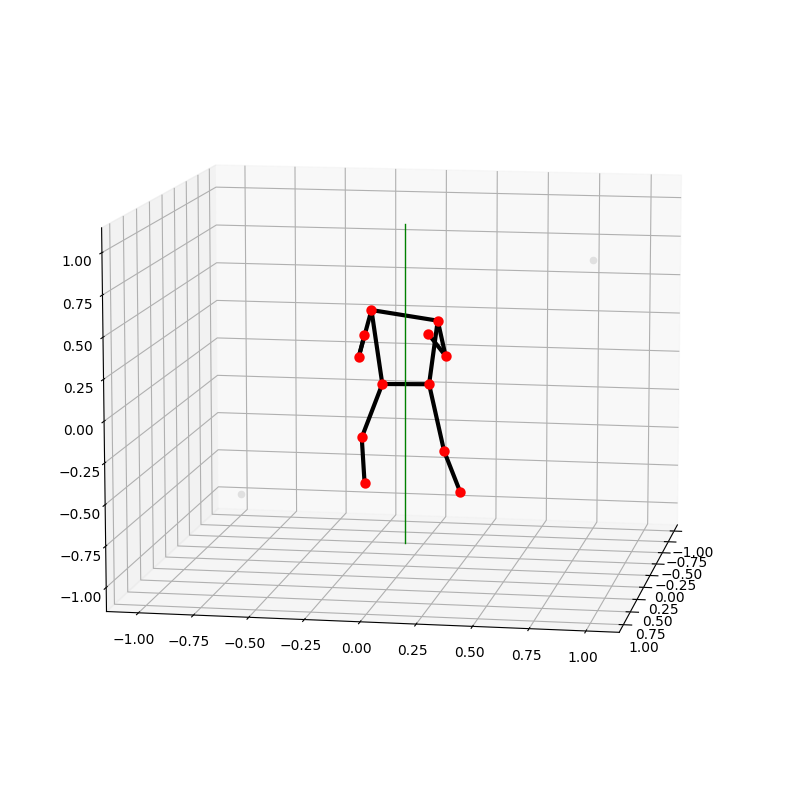

<Figure size 640x480 with 0 Axes>

In [6]:
img_path = './../data/img1.png'
vid_path = './../data/vid1.png'

with mp_pose.Pose(
    static_image_mode=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=2) as pose:
    image = cv2.imread(img_path)
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS, show=True, save_path='3dpic.png')
    # cv2.imshow("Someimage",image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 

In [6]:
def from_video(path, save=True):
    cap = cv2.VideoCapture(path)
    cnt = 1
    frames = 100
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('pose2.mp4', fourcc, 20.0, (480,640))
    out2 = cv2.VideoWriter('pose3d_4.mp4', fourcc, 20.0, (480,640))
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=2) as pose:
        while cap.isOpened() and cnt < frames:
            for i in tqdm(range(0, frames)):
                success, image = cap.read()
                if not success:
                    break

                image = cv2.flip(image, -1)
                image.flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = pose.process(image)

                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                mp_drawing.draw_landmarks(
                    image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
                image = cv2.resize(image, (480, 640))
                # cv2.imshow('Pose detection', cv2.flip(image, -1))
                if save:
                    out.write(image)
                    figid = '3d/' + str(cnt) + '.png'
                    plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS, save_path=figid, azimuth=cnt*2)
                    img = cv2.imread(figid)
                    img = cv2.resize(img, (480, 640))
                    out2.write(img)
                cnt = cnt + 1
                if cv2.waitKey(5) & 0xFF == 27:
                    break
    cap.release()
    out.release()
    out2.release()
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 

In [59]:
from_video('./data/videos/vid1.mp4')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.64s/it]


<Figure size 640x480 with 0 Axes>